In [107]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import json
from PIL import Image
import os
import io
from google.cloud import storage
import torch
import torchvision
import numpy as np
import matplotlib.patches as patches

In [166]:
class FishnetDataset(Dataset):
    def __init__(self, labels_file, bucket_name, gcp_cred_path, transform=None, resize_shape: tuple = (400, 800)):
        self.label_dict = json.load(open(labels_file))
        self.label_list = list(self.label_dict.keys())
        self.bucket_name = bucket_name
        self.transform = transform
        os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = gcp_cred_path
        self.storage_client = storage.Client()
        self.bucket = self.storage_client.bucket(bucket_name)
        self.resize_shape = resize_shape

    def __len__(self):
        return len(self.label_dict)

    def __getitem__(self, idx):
        blob = self.bucket.blob(self.label_list[idx] + ".jpg")
        img_bytes = blob.download_as_bytes()

        # Convert bytes to an image
        img = Image.open(io.BytesIO(img_bytes)).convert('RGB')

        # Find the resizing scales for x and y
        x_scale = self.resize_shape[1] / img.size[0]
        y_scale = self.resize_shape[0] / img.size[1]

        # Transform, if any
        if self.transform:
            img = self.transform(img)

        # Get the label
        target = self.label_dict[self.label_list[idx]][1]

        # Scale the bounding boxes
        for i in range(len(target)):
            for j in range(2):
                target[i][0][j] = str(int(int(target[i][0][j]) * x_scale))
                target[i][1][j] = str(int(int(target[i][1][j]) * y_scale))

        # Pad the target with missing values
        while len(target) < 20:
            target.append([["-1","-1"], ["-1","-1"], "Missing"])

        return img, target


In [167]:
def display_bounding_boxes(input_image: torch.Tensor, model_outputs: dict, thresh = 0.8):

    boxes = model_outputs[0]['boxes']
    cleaned_boxes = []
    for box in boxes:
        box = box.detach().numpy()
        box = box.astype(int)
        cleaned_boxes.append(box)

    scores = model_outputs[0]['scores']
    for i in range(len(scores)):
        if scores[i] < thresh:
            cleaned_boxes[i] = None
            
    cleaned_boxes = [box for box in cleaned_boxes if box is not None]

    # Create figure and axes
    fig, ax = plt.subplots()
    # Display the image
    ax.imshow(input_image[0].permute(1, 2, 0))

    # Create a Rectangle patch for each cleaned box and add to the plot
    for box in cleaned_boxes:
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)


In [168]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Define the transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((400, 800))
])

# Create the dataset
dataset = FishnetDataset(labels_file="../data/labels.json", 
                         bucket_name="fishnet3-object-detection", 
                         gcp_cred_path="../fishnet3-56e06381ff35.json", 
                         transform=transform,
                         resize_shape=(400, 800))


In [169]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [170]:
# Create train, val, test splits
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


[[['238', '287'], ['50', '126'], 'Human'], [['288', '324'], ['27', '99'], 'Human'], [['330', '360'], ['54', '88'], 'Human'], [['347', '395'], ['11', '81'], 'Human'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing']]


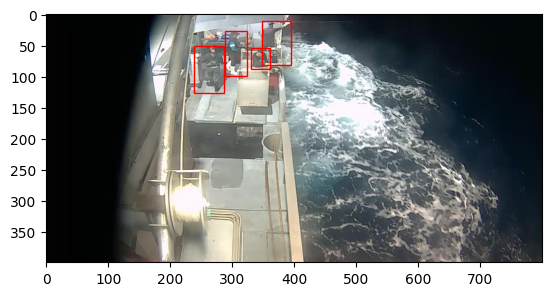

[[['171', '366'], ['320', '387'], 'Yellowfin tuna'], [['191', '321'], ['230', '277'], 'Yellowfin tuna'], [['317', '469'], ['216', '317'], 'Yellowfin tuna'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing'], [['-1', '-1'], ['-1', '-1'], 'Missing']]


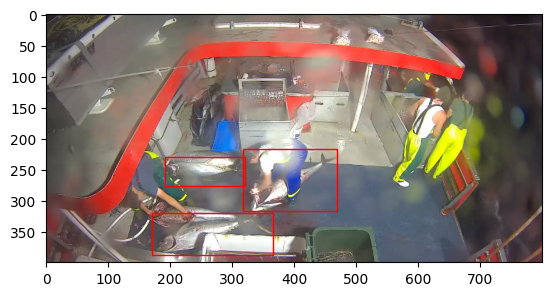

In [172]:

# Get a batch of training data
inputs, targets = next(iter(train_loader))

# For each image in the imputs, display it by itself
for i in range(len(inputs)):
    img = inputs[i]
    img = img.permute(1, 2, 0)
    plt.imshow(img)
    # Draw the bounding boxes
    target = targets[i]
    print(target)

    for box in target:
        if box[2] == "Missing":
            continue
        xs = box[0]
        ys = box[1]
        xs = [int(x) for x in xs]
        ys = [int(y) for y in ys]

        rect = patches.Rectangle((xs[0], ys[0]), xs[1]-xs[0], ys[1]-ys[0], linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)


    plt.show()



plt.show()